In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import shutil
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Datasets paths
dataset_path_1 = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
dataset_path_2 = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_6_classes')

# Target classes
target_classes = ['paper', 'plastic', 'glass']

In [3]:
# Mapping for the 12-class dataset 
mapping_12_to_3 = {
    'cardboard': 'paper',
    'paper': 'paper',
    'brown-glass': 'glass',
    'green-glass': 'glass',
    'white-glass': 'glass',
    'plastic': 'plastic',
    'metal': None,  
    'biological': None,
    'trash': None,
    'clothes': None,
    'shoes': None,
    'battery': None
}

# Mapping for the 6-class dataset
mapping_6_to_3 = {
    'paper': 'paper',
    'plastic': 'plastic',
    'glass': 'glass',
    'cardboard': 'paper', 
    'metal': None,  
    'trash': None  
}

In [4]:
def load_and_map_data(dataset_path, mapping):
    data = []
    all_classes = os.listdir(dataset_path)
    for original_class in all_classes:
        mapped_class = mapping.get(original_class)
        if mapped_class in target_classes:
            class_path = os.path.join(dataset_path, original_class)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append({'image_path': img_path, 'class': mapped_class})
    return data

data_12 = load_and_map_data(dataset_path_1, mapping_12_to_3)
data_6 = load_and_map_data(dataset_path_2, mapping_6_to_3)

print(data_12)
print(data_6)

[{'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass1.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass10.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass100.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass101.jpg', 'class': 'glass'}, {'image_path': 'C:\\Users\\ruben\\OneDrive\\Escritorio\\IRONHACK\\final_project\\datasets\\garbage_classification_12_classes\\garbage_classification\\brown-glass\\brown-glass102.jpg', 'class

In [5]:
# Unifying data
combined_data = data_12 + data_6
df_combined = pd.DataFrame(combined_data)
df_combined

,image_path,class
0,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,glass
1,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,glass
2,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,glass
3,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,glass
4,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,glass
...,...,...
6792,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,plastic
6793,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,plastic
6794,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,plastic
6795,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,plastic


C:\Users\ruben\AppData\Local\Temp\ipykernel_17860\3010428703.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=initial_class_counts.index,


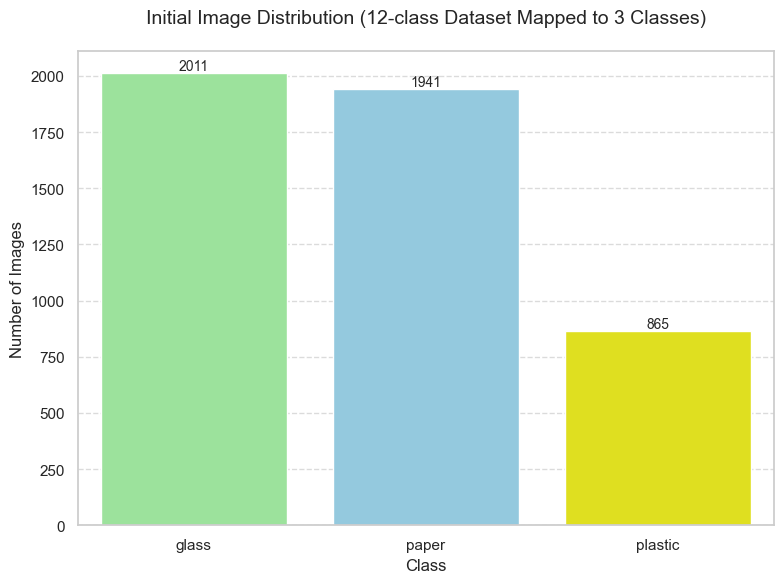


Image count from initial 12-class dataset (mapped to 3 classes)
class
glass      2011
paper      1941
plastic     865
Name: count, dtype: int64


In [6]:
data_12 = load_and_map_data(dataset_path_1, mapping_12_to_3)
df_12 = pd.DataFrame(data_12)

initial_class_counts = df_12['class'].value_counts()

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid", palette="pastel")

ax = sns.barplot(x=initial_class_counts.index, 
                 y=initial_class_counts.values,
                 palette=['lightgreen', 'skyblue', 'yellow'],
                 width=0.8)

plt.title('Initial Image Distribution (12-class Dataset Mapped to 3 Classes)', 
          fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nImage count from initial 12-class dataset (mapped to 3 classes)")
print(initial_class_counts)

In [7]:
class_counts = df_combined['class'].value_counts()
print("\nClass Count:\n", class_counts)


Class Count:
 class
paper      2938
glass      2512
plastic    1347
Name: count, dtype: int64


C:\Users\ruben\AppData\Local\Temp\ipykernel_17860\1169863742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(class_counts.keys()),


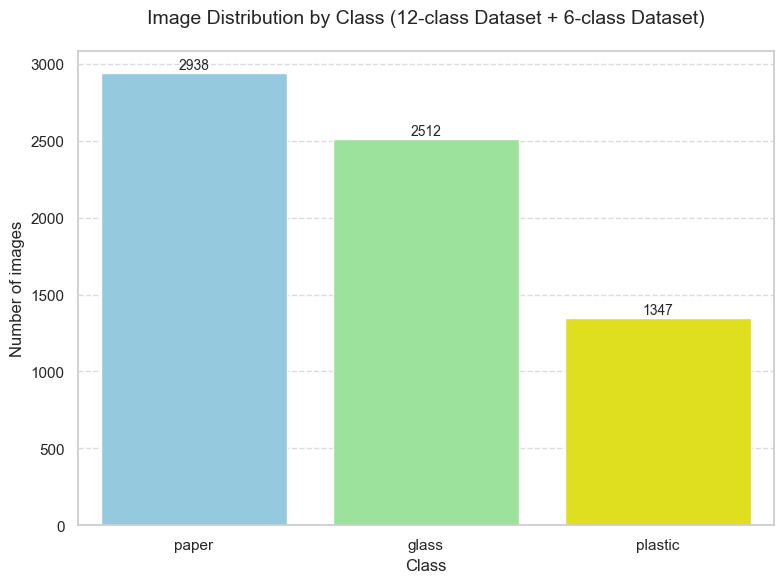

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(8, 6))

ax = sns.barplot(x=list(class_counts.keys()), 
                 y=list(class_counts.values), 
                 palette=['skyblue', 'lightgreen', 'yellow'],
                 width=0.8)  

plt.title('Image Distribution by Class (12-class Dataset + 6-class Dataset)', fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10,
                xytext=(0, 1),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
folder_path = os.path.join(os.pardir, 'data', 'raw_images', 'api_images')
target_folders = ['paper', 'plastic', 'glass']
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

image_counts = Counter()

for folder_name in target_folders:
    folder_path_full = os.path.join(folder_path, folder_name)
    count = 0
    for filename in os.listdir(folder_path_full):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            count += 1
    image_counts[folder_name] = count

print("\nImage count per folder")
for folder, count in image_counts.items():
    print(f"Folder '{folder}': {count} images")


Image count per folder
Folder 'paper': 115 images
Folder 'plastic': 292 images
Folder 'glass': 203 images


In [ ]:
api_path = os.path.join(os.pardir, 'data', 'raw_images', 'api_images')

In [ ]:
# Adding images from the Pexels path
api_data = []
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

for folder_name in target_classes:
    folder_path_full = os.path.join(api_path, folder_name)
    for filename in os.listdir(folder_path_full):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            img_path = os.path.join(folder_path_full, filename)
            api_data.append({'image_path': img_path, 'class': folder_name})

# Convert data from Pexels to DataFrame and concatenate
df_api = pd.DataFrame(api_data)
df_combined_all = pd.concat([df_combined, df_api], ignore_index=True)

print("\nDataFrame combined after adding images from API's and google images:")
print(df_combined_all.head())
print(f"Final number of rows: {len(df_combined_all)}")

# Count number of images per class in the final DataFrame
final_class_counts = df_combined_all['class'].value_counts()
print("\n-Image count per class in the final DataFrame:")
print(final_class_counts)


DataFrame combined after adding images from API's and google images:
                                          image_path  class
0  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
1  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
2  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
3  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
4  C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...  glass
Final number of rows: 7407

-Image count per class in the final DataFrame:
class
paper      3053
glass      2715
plastic    1639
Name: count, dtype: int64


C:\Users\ruben\AppData\Local\Temp\ipykernel_17860\4092060427.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=final_class_counts.index,


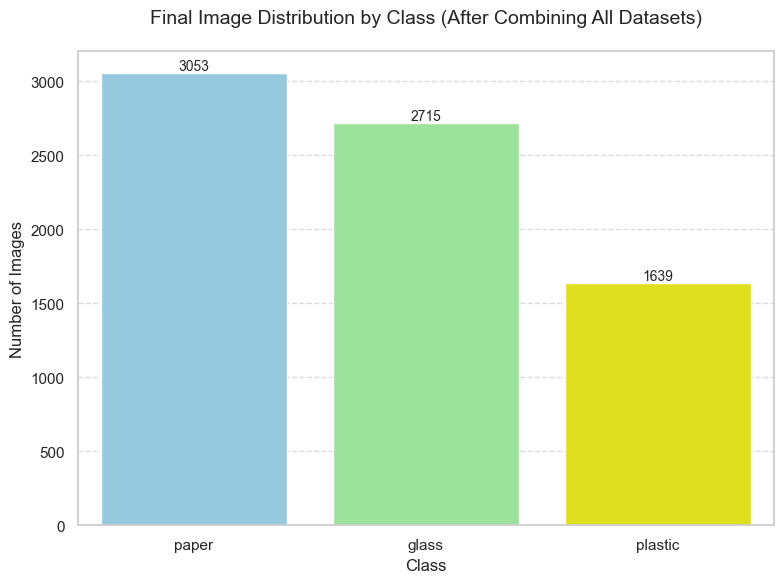

In [12]:
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid", palette="pastel")

# Create the bar plot
ax = sns.barplot(x=final_class_counts.index, 
                 y=final_class_counts.values,
                 palette=['skyblue', 'lightgreen', 'yellow'], width=0.8)

# Add title and labels
plt.title('Final Image Distribution by Class (After Combining All Datasets)', 
          fontsize=14, pad=20)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=0)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points',
                fontsize=10)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [13]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42
target_classes = ['paper', 'plastic', 'glass']

In [14]:
train_df, temp_df = train_test_split(
    df_combined_all,
    test_size=0.2,
    random_state=SEED,
    stratify=df_combined_all['class']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_df['class']
)

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None, 
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes,
    seed=SEED,
    shuffle=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None, 
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes,
    seed=SEED,
    shuffle=False
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  
    x_col="image_path",
    y_col="class",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=target_classes,
    seed=SEED,
    shuffle=False
)

Found 5919 validated image filenames belonging to 3 classes.
Found 741 validated image filenames belonging to 3 classes.


c:\Users\ruben\anaconda3\envs\tf_python39\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 6 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 741 validated image filenames belonging to 3 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(target_classes), activation='softmax')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint_filepath = 'best_model_3_classes.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)
callbacks_list = [early_stopping, lr_scheduler, model_checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list
)

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50
184/184 [==============================] - ETA: 0s - loss: 1.1417 - accuracy: 0.4693
Epoch 1: val_loss improved from inf to 1.20251, saving model to best_model_3_classes.h5
184/184 [==============================] - 257s 1s/step - loss: 1.1417 - accuracy: 0.4693 - val_loss: 1.2025 - val_accuracy: 0.3709 - lr: 1.0000e-04
Epoch 2/50
184/184 [==============================] - ETA: 0s - loss: 1.0373 - accuracy: 0.5132
Epoch 2: val_loss improved from 1.20251 to 0.97963, saving model to best_model_3_classes.h5
184/184 [==============================] - 284s 2s/step - loss: 1.0373 - accuracy: 0.5132 - val_loss: 0.9796 - val_accuracy: 0.4837 - lr: 1.0000e-04
Epoch 3/50
184/184 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.5471
Epoch 3: val_loss did not improve from 0.97963
184/184 [==============================] - 288s 2s/step - loss: 0.9945 - accuracy: 0.5471 - val_loss: 1.0281 - val_accuracy: 0.5272 - lr: 1.0000e-04
Epoch 4/50
184/184 [==================

In [ ]:
# Load the best saved model
best_model = load_model('best_model_3_classes.h5')

# Evaluate the model in the test generator
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report using test_generator
y_pred_probs = best_model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = []
for i in range(test_generator.samples // BATCH_SIZE):
    _, labels = test_generator[i]
    y_true.extend(np.argmax(labels, axis=1))
y_true = np.array(y_true)

report = classification_report(y_true, y_pred, target_names=target_classes, zero_division=0)
print("Classification Report (Test Set):\n", report)

23/23 [==============================] - 28s 1s/step - loss: 0.7988 - accuracy: 0.6658
Test Loss: 0.7988
Test Accuracy: 0.6658
23/23 [==============================] - 29s 1s/step
Classification Report (Test Set):
               precision    recall  f1-score   support

       paper       0.68      0.74      0.71       303
     plastic       0.60      0.57      0.58       162
       glass       0.69      0.64      0.66       271

    accuracy                           0.67       736
   macro avg       0.66      0.65      0.65       736
weighted avg       0.67      0.67      0.66       736



In [ ]:
loss_val, accuracy_val = best_model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE, verbose=0)
print(f"Validation Loss: {loss_val:.4f}")
print(f"Validation Accuracy: {accuracy_val:.4f}")

y_pred_val_probs = best_model.predict(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
y_pred_val = np.argmax(y_pred_val_probs, axis=1)

y_true_val = []
for i in range(validation_generator.samples // BATCH_SIZE):
    _, labels = validation_generator[i]
    y_true_val.extend(np.argmax(labels, axis=1))
y_true_val = np.array(y_true_val)

report_val = classification_report(y_true_val, y_pred_val, target_names=target_classes, zero_division=0)
print("Classification Report (Validation Set):\n", report_val)

Validation Loss: 0.8010
Validation Accuracy: 0.6440
23/23 [==============================] - 31s 1s/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

       paper       0.68      0.77      0.72       303
     plastic       0.51      0.43      0.46       164
       glass       0.67      0.64      0.65       269

    accuracy                           0.64       736
   macro avg       0.62      0.61      0.61       736
weighted avg       0.64      0.64      0.64       736



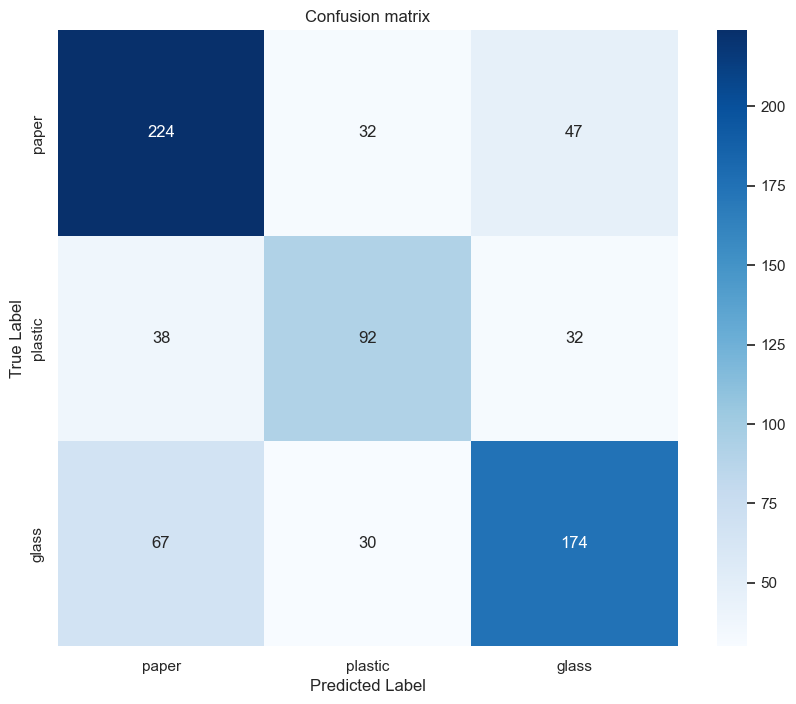

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

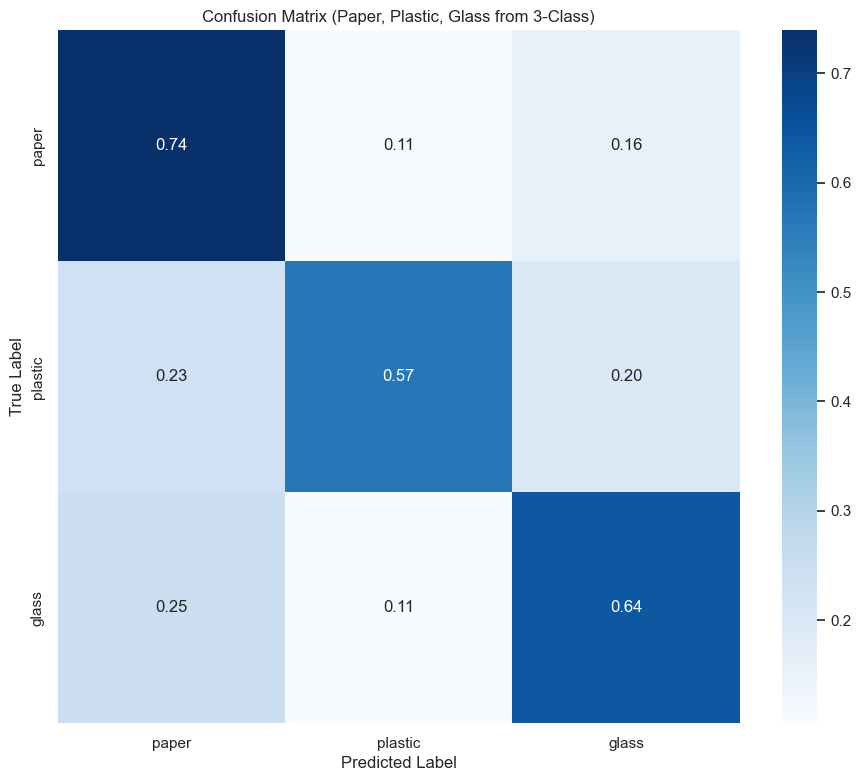

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Paper, Plastic, Glass from 3-Class)')
plt.show()

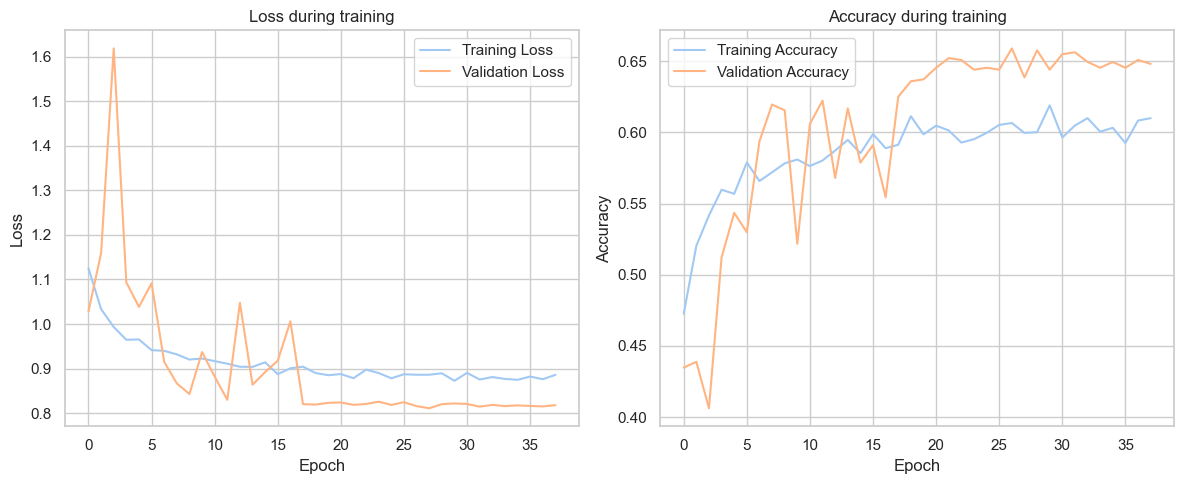

In [22]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Tableau

In [ ]:
import pandas as pd
from tensorflow.keras.callbacks import History

def save_training_history_with_epoch(history: History, filename='training_history3.csv'):
    history_dict = history.history
    epoch_count = len(history_dict.get('loss', []))  # Get the number of epochs from the history

    # Create an 'epoch' list
    epochs = list(range(1, epoch_count + 1))

    # Add the 'epoch' list to the history dictionary
    history_dict['epoch'] = epochs

    history_df = pd.DataFrame(history_dict)
    history_df.to_csv(filename, index=False)



In [ ]:
save_training_history_with_epoch(history)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history3.csv', index=False)

In [ ]:
cm_normalized = pd.DataFrame(cm_normalized, index=target_classes, columns=target_classes)
cm_normalized.to_csv('confusion_matrix_normalized3.csv')